# 1D

In [ ]:
import split_op as split
import numpy as np

def lennard_jones(x, d6, r6):
    r_pow6 = (r6 / x) ** 6
    return d6 * r_pow6 * (r_pow6 - 2)

mass = 6.0
energy = 1e-7
kelvin = 3.1668105e-6
momentum = np.sqrt(2 * mass * energy * kelvin * 1820)

grid = split.Grid.linear_continuos("x", 8.0, 20.0, 512, 0)

time_grid = split.TimeGrid(50.0, 1000, True)

array = np.zeros(grid.nodes_no(), dtype=complex)
points = grid.points()
for i in range(len(points)):
    array[i] = split.gaussian_distribution(points[i], 14.0, 2.0, momentum)
wave_function = split.WaveFunction(array, [grid])

r6 = 9.7
d6 = 0.0003
potential_array = np.zeros(grid.nodes_no())
for i in range(len(points)):
    potential_array[i] = lennard_jones(points[i], d6, r6)
potential_propagator = split.one_dim_into_propagator(potential_array, grid, time_grid)

kinetic_operator = split.kinetic_hamiltonian(grid, mass)
kinetic_propagator = split.one_dim_into_propagator(kinetic_operator, grid, time_grid, step="full")

fft_transformation = split.FFTTransformation(grid, "momentum")

wave_saver = split.StateSaver("data/lj_ground", time_grid, grid, 120)
leak_control = split.LeakControl(split.LossChecker("leak control"))

operation_stack = split.OperationStack()
leak_control.add_operation(operation_stack)
wave_saver.add_operation(operation_stack)
potential_propagator.add_operation(operation_stack)
fft_transformation.add_operation(operation_stack, inverse_second=True)
kinetic_propagator.add_operation(operation_stack)

propagation = split.Propagation()
propagation.set_time_grid(time_grid)
propagation.set_wave_function(wave_function)
propagation.set_operation_stack(operation_stack)


propagation.propagate()
propagation.save_savers()

In [2]:
from matplotlib import animation
import numpy as np
import matplotlib.pyplot as plt

def wave_animation(prefix, grid_name, xlabel, with_potential=False): 
    wave = np.load(f'data/{prefix}.npy')
    grid = np.load(f'data/{prefix}_{grid_name}_grid.npy')

    if with_potential:
        potential = np.load(f'data/{prefix}_potential.npy')

    fig, ax = plt.subplots()

    def animate(i):
        ax.clear()
        ax.plot(grid, wave[:, i])
        if with_potential:
            ax.plot(grid, potential * np.max(wave[:, i]) / np.max(potential), color='black') # type: ignore
            
        ax.set_xlabel(xlabel)
        ax.set_ylabel("wave function density")

        return []

    anim = animation.FuncAnimation(fig, animate, interval=60, frames=wave.shape[1], blit=False)
    return anim

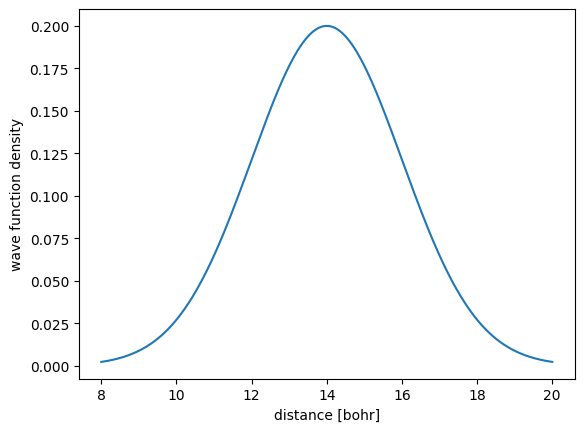

In [3]:
anim = wave_animation("lj_ground", "x", "distance [bohr]", False)
anim.save('plots/lj_ground_animation.gif', writer="pillow", fps=30);

In [ ]:
import split_op as split
import numpy as np

def harmonic(x, mass, omega):
    return 0.5 * mass * omega ** 2 * x ** 2

U = 1822.88839
KELVIN = 3.1668105e-6
mass = 6.0
energy = 1e-7
momentum = np.sqrt(2 * mass * energy * KELVIN * U)
omega = 2e-4

grid = split.Grid.linear_continuos("x", -10.0, 10.0, 512, 0)
weights = grid.weights()

time_grid = split.TimeGrid(50.0, 1000, True)

array = np.zeros(grid.nodes_no(), dtype=complex)
points = np.array(grid.points())
for i in range(len(points)):
    array[i] = split.gaussian_distribution(points[i], 2., 2., momentum)
wave_function = split.WaveFunction(array, [grid])

potential_array = np.zeros(grid.nodes_no())
for i in range(len(points)):
    potential_array[i] = harmonic(points[i], mass * U, omega)
potential_propagator = split.one_dim_into_propagator(potential_array, grid, time_grid)

kinetic_operator = split.kinetic_hamiltonian(grid, mass)
kinetic_propagator = split.one_dim_into_propagator(kinetic_operator, grid, time_grid, step="full")

fft_transformation = split.FFTTransformation(grid, "momentum")

wave_saver = split.StateSaver("data/harmonic_ground", time_grid, grid, 120)
leak_control = split.LeakControl(split.LossChecker("leak control"))

operation_stack = split.OperationStack()
leak_control.add_operation(operation_stack)
wave_saver.add_operation(operation_stack)
potential_propagator.add_operation(operation_stack)
fft_transformation.add_operation(operation_stack, inverse_second=True)
kinetic_propagator.add_operation(operation_stack)

propagation = split.Propagation()
propagation.set_time_grid(time_grid)
propagation.set_wave_function(wave_function)
propagation.set_operation_stack(operation_stack)

propagation.propagate()
propagation.save_savers()

9.99995807181162e-05


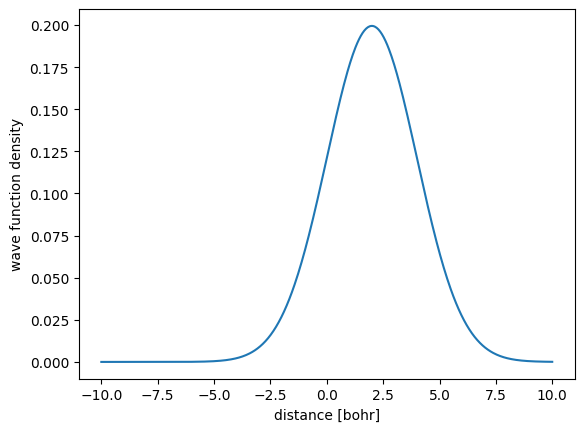

In [5]:
print(propagation.mean_energy())

anim = wave_animation("harmonic_ground", "x", "distance [bohr]", False)
anim.save('plots/harmonic_ground_animation.gif', writer="pillow", fps=30);

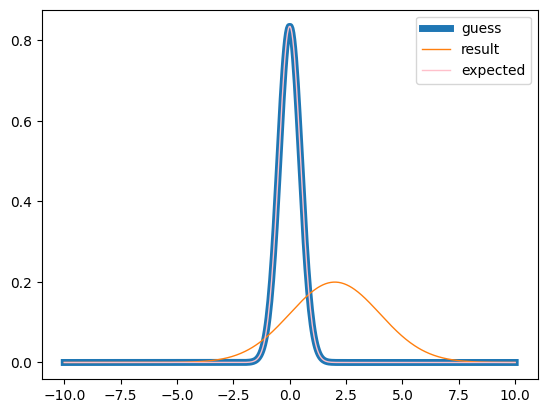

In [6]:
wave = np.load(f'data/harmonic_ground.npy')
grid = np.load(f'data/harmonic_ground_x_grid.npy')

predicted = np.power(mass * U * omega / np.pi, 0.25) * np.exp(-mass * U * omega / 2 * grid * grid)

fig, ax = plt.subplots()
ax.plot(grid, wave[:, -1], linewidth = 5, label = "guess")
ax.plot(grid, wave[:, 0], linewidth = 1, label = "result")
ax.plot(grid, predicted ** 2, linewidth = 1, label = "expected", color="pink")
ax.legend();

In [ ]:
import split_op as split
import numpy as np

mass = 6.0
energy = 3000
momentum = np.sqrt(2 * mass * U * energy * KELVIN)

grid = split.Grid.linear_continuos("x", 0.0, 30.0, 512, 0)

time_grid = split.TimeGrid(50.0, 1000)

print(momentum / mass / U * 50 * 1000)

array = np.zeros(grid.nodes_no(), dtype=complex)
points = grid.points()
for i in range(len(points)):
    array[i] = split.gaussian_distribution(points[i], 24.0, 1.0, momentum)
wave_function = split.WaveFunction(array, [grid])

potential_array = np.zeros(grid.nodes_no())
potential_propagator = split.one_dim_into_propagator(potential_array, grid, time_grid)

kinetic_operator = split.kinetic_hamiltonian(grid, mass)
kinetic_propagator = split.one_dim_into_propagator(kinetic_operator, grid, time_grid, step="full")

fft_transformation = split.FFTTransformation(grid, "momentum")

wave_saver = split.StateSaver("data/free_wave", time_grid, grid, 120)
leak_control = split.LeakControl(split.LossChecker("leak control"))

operation_stack = split.OperationStack()
leak_control.add_operation(operation_stack)
wave_saver.add_operation(operation_stack)
potential_propagator.add_operation(operation_stack)
fft_transformation.add_operation(operation_stack, inverse_second=True)
kinetic_propagator.add_operation(operation_stack)

propagation = split.Propagation()
propagation.set_time_grid(time_grid)
propagation.set_wave_function(wave_function)
propagation.set_operation_stack(operation_stack)

propagation.propagate()
propagation.save_savers()

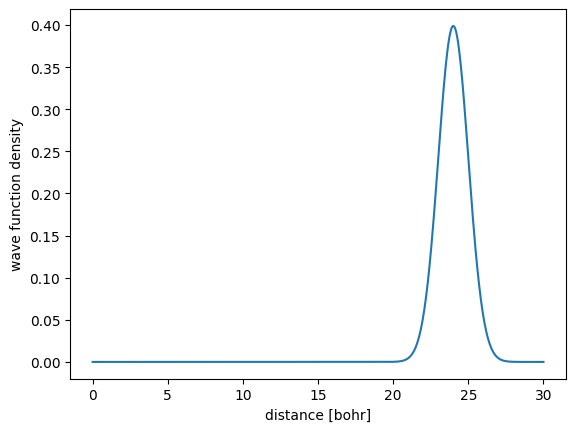

In [8]:
anim = wave_animation("free_wave", "x", "distance [bohr]", False)
anim.save('plots/free_wave_animation.gif', writer="pillow", fps=30)

# 2D

In [ ]:
import split_op as split
import numpy as np
from scipy.special import roots_legendre, lpmv

mass = 6.0
energy = 3000
proj_init = 0

omega_z = 1e-4
omega_xy = 1e-4

momentum = np.sqrt(2 * mass * U * energy * KELVIN)

time_grid = split.TimeGrid(50.0, 1000, im_time = True)

r_grid = split.Grid.linear_continuos("r", 10 / 512, 10.0, 512, 0)
r_points = np.array(r_grid.points())

polar_points, weights = roots_legendre(100)
polar_points = np.flip(np.arccos(polar_points))
weights = np.flip(weights)

polar_grid = split.Grid.custom("theta", polar_points, weights, 1)

wave_r_init = np.array([split.gaussian_distribution(r_points[i], 5., 2., momentum) for i in range(r_grid.nodes_no())])
wave_polar_init = lpmv(proj_init, proj_init, np.cos(polar_points))
wave_init = np.outer(wave_r_init, wave_polar_init)
wave_function = split.WaveFunction(wave_init.flatten(), [r_grid, polar_grid])

r_mesh, polar_mesh = np.meshgrid(r_points, polar_points, indexing="ij")

potential_array = 0.5 * mass * U * (r_mesh - 5.) ** 2 * ((omega_z * np.cos(polar_mesh)) ** 2 + (omega_xy * np.sin(polar_mesh)) ** 2)
potential_propagator = split.n_dim_into_propagator(potential_array.shape, potential_array.flatten(), time_grid)

angular_transformation = split.associated_legendre_transformation(polar_grid, proj_init)

shape, angular_kinetic_op = split.rotational_hamiltonian(r_grid, polar_grid, mass, 0.)
angular_prop = split.n_dim_into_propagator(shape, angular_kinetic_op, time_grid)

kinetic_operator = split.kinetic_hamiltonian(r_grid, mass)
kinetic_propagator = split.one_dim_into_propagator(kinetic_operator, r_grid, time_grid, step="full")

fft_transformation = split.FFTTransformation(r_grid, "momentum")

wave_saver = split.StateSaver("data/2d_harmonic_wave", time_grid, r_grid, 120)
wave_2d_saver = split.WaveFunctionSaver("data/2d_harmonic_wave_2d", time_grid, r_grid, polar_grid, 120)
angular_saver = split.StateSaver("data/2d_harmonic_angular", time_grid, angular_transformation.transformed_grid(), 120)
leak_control = split.LeakControl(split.LossChecker("leak control"))

operation_stack = split.OperationStack()
leak_control.add_operation(operation_stack)
wave_2d_saver.add_operation(operation_stack)
wave_saver.add_operation(operation_stack)
potential_propagator.add_operation(operation_stack)
angular_transformation.add_operation(operation_stack, inverse_second=True)
angular_saver.add_operation(operation_stack)
angular_prop.add_operation(operation_stack)
fft_transformation.add_operation(operation_stack, inverse_second=True)
kinetic_propagator.add_operation(operation_stack)

propagation = split.Propagation()
propagation.set_time_grid(time_grid)
propagation.set_wave_function(wave_function)
propagation.set_operation_stack(operation_stack)

propagation.propagate()
propagation.save_savers()

propagation.propagate()
propagation.save_savers()

4.999994867020422e-05


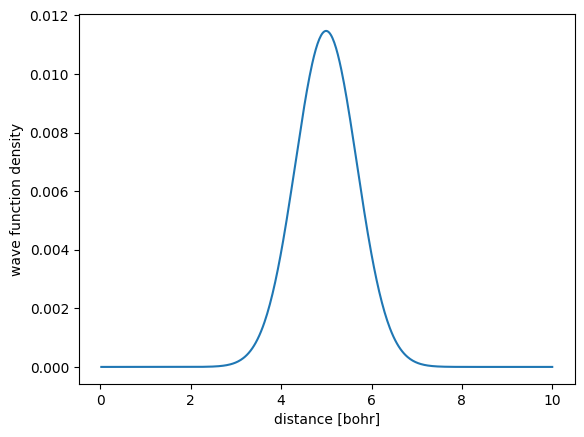

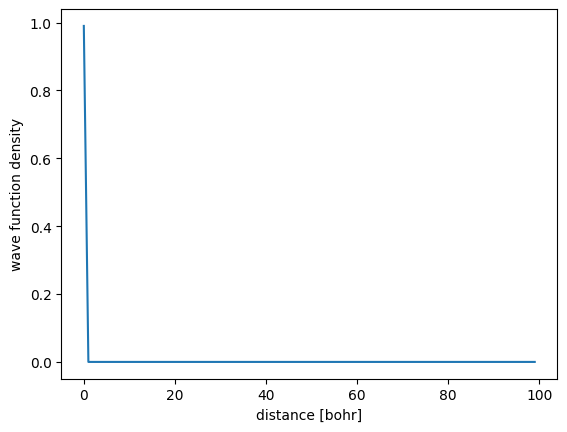

In [10]:
print(propagation.mean_energy())

anim = wave_animation("2d_harmonic_wave", "r", "distance [bohr]", False)
anim.save('plots/2d_harmonic_wave_animation.gif', writer="pillow", fps=30)

anim = wave_animation("2d_harmonic_angular", "angular_momentum", "distance [bohr]", False)
anim.save('plots/2d_harmonic_angular_animation.gif', writer="pillow", fps=30)

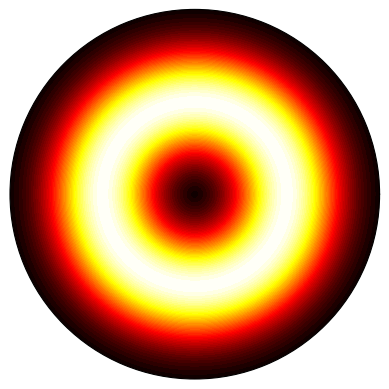

In [11]:
def wave_into_polar(polar, values):
    polar = np.concatenate(([0], polar))
    values = np.concatenate((values[:, 0:1], values), axis=1)

    polar = np.concatenate((polar, np.flip(-polar)))
    values = np.concatenate((values, np.flip(values, axis=1)), axis=1)

    return polar, values

def wave_2d_animation(filename: str):
    wave = np.load(f'data/{filename}_wave_2d.npy')
    r = np.load(f'data/{filename}_wave_2d_x_grid.npy')
    polar = np.load(f'data/{filename}_wave_2d_y_grid.npy')

    polar, wave = wave_into_polar(polar, wave)

    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    def animate(i: int):
        ax.clear()
        ax.contourf(polar, r, wave[:, :, i], cmap='hot', levels=50)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(False)
        
        return []

    return animation.FuncAnimation(fig, animate, interval=60, frames=wave.shape[2], blit=False)

anim = wave_2d_animation("2d_harmonic")
anim.save(f"plots/2d_harmonic_wave_2d_animation.gif", writer="pillow", fps=30)

# Rb K Rb

In [2]:
import split_op as split
import numpy as np

def lennard_jones(x, d6, r6):
    r_pow6 = (r6 / x) ** 6
    return d6 * r_pow6 * (r_pow6 - 2)

mass = 1 / (1 / 40 + 2 / 87) 
energy = 10.0
kelvin = 3.1668105e-6
momentum = np.sqrt(2 * mass * 1820 * energy * kelvin)

x_grid = split.Grid.linear_continuos("x", 6.0, 60.0, 512, 0)
y_grid = split.Grid.linear_continuos("y", 6.0, 60.0, 512, 1)

time_grid = split.TimeGrid(1000.0, 5000)

array = np.zeros((x_grid.nodes_no(), y_grid.nodes_no()), dtype=complex)
x_points = x_grid.points()
y_points = y_grid.points()
for i in range(len(x_points)):
    for j in range(len(y_points)):
        array[i, j] = split.gaussian_distribution(x_points[i], 20.0, 2.0, momentum / 4) \
                    * split.gaussian_distribution(y_points[j], 40.0, 2.0, momentum)

wave_function = split.WaveFunction(array.flatten(), [x_grid, y_grid])

In [3]:
import scipy
import scipy.optimize as opt

cm_inv = 219474.63
ps = 0.000024188843
ns = ps / 1000
angs = 1.88973

class Potential:
    def __init__(self, C6, C8, eta, a_k, c_nk) -> None:
        self.C6 = C6
        self.C8 = C8
        self.eta = eta
        self.a_k = a_k
        self.c_nk = c_nk

    def tang_dumping(self, n, x):
        return 1 - np.exp(-x) * sum(x ** i / scipy.special.factorial(i) for i in range(n+1))
    
    def tail(self, r):
        return -self.C6 / r ** 6 * self.tang_dumping(6, self.eta * r) - self.C8 / r ** 8 * self.tang_dumping(8, self.eta * r)

    def barrier(self, r):
        cumulative = 0
        for (a, c_n) in zip(self.a_k, self.c_nk):
            cumulative += np.exp(-a * r) * sum(c * r ** n for (n, c) in enumerate(c_n))
        return cumulative
    
    def value(self, r):
        return self.tail(r) * cm_inv + self.barrier(r) * cm_inv

def r_rb_rb(x, y):
    return np.sqrt(x **2 + y ** 2 - 2 * np.cos(np.pi * 5.0 / 18.0) * x * y)

def full_potential(x, y, inf):
    return potential_KRb.value(x) + potential_KRb.value(y) + potential_RbRb.value(r_rb_rb(x, y)) + inf

def potential_changer(x, inf, C6, C8, eta, a_1, a_2, c_11, c_12, c_13, c_21, c_22, c_23, C6_2, C8_2, eta_2, a_1_2, a_2_2, c_11_2, c_12_2, c_13_2, c_21_2, c_22_2, c_23_2):
    potential_KRb.C6 = C6
    potential_KRb.C8 = C8
    potential_KRb.eta = eta
    potential_KRb.a_k = [a_1, a_2]
    potential_KRb.c_nk = [[c_11, c_12, c_13], [c_21, c_22, c_23]]

    potential_RbRb.C6 = C6_2
    potential_RbRb.C8 = C8_2
    potential_RbRb.eta = eta_2
    potential_RbRb.a_k = [a_1_2, a_2_2]
    potential_RbRb.c_nk = [[c_11_2, c_12_2, c_13_2], [c_21_2, c_22_2, c_23_2]]


    return full_potential(x[0], x[1], inf)

data = np.loadtxt('data/potential.dat', skiprows=3, usecols=range(3, 21))
x = np.loadtxt('data/potential.dat', skiprows=0, usecols=0)[2::]

x1, x2 = np.meshgrid(x, x)
xdata = np.vstack((x1.ravel(), x2.ravel()))
ydata = data.ravel()

potential_KRb = Potential(5614.933575483628, -207304.86611934795, 10000000.0, [200000000.0, 217836807.1193298], [[3.0, -2.12675, 0.0554], [20.026, -144.25, 371.6]])
potential_RbRb = Potential(5614.933575483628, -207304.86611934795, 10000000.0, [200000000.0, 217836807.1193298], [[3.0, -2.12675, 0.0554], [20.026, -144.25, 371.6]])
p0 = [4000, 5614.933575483628, -207304.86611934795, 10000000.0, 200000000.0, 217836807.1193298, 3.0, -2.12675, 0.0554, 20.026, -144.25, 371.6, 
    5614.933575483628, -207304.86611934795, 10000000.0, 200000000.0, 217836807.1193298, 3.0, -2.12675, 0.0554, 20.026, -144.25, 371.6]

result, err = opt.curve_fit(potential_changer, xdata, ydata, sigma=0.01 * ydata, p0=p0)

x_ext = x_points
potential = np.zeros((len(x_ext), len(x_ext)))
for i in range(len(x_ext)):
    for j in range(len(x_ext)):
        potential[i, j] = full_potential(x_ext[i], x_ext[j], result[0])
np.clip(potential, -5000.0, 10000, out=potential)
potential *= kelvin

/tmp/ipykernel_103535/1563385500.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  result, err = opt.curve_fit(potential_changer, xdata, ydata, sigma=0.01 * ydata, p0=p0)


In [ ]:
time_grid = split.TimeGrid(1000.0, 5000)
potential_propagator = split.n_dim_into_propagator(potential.shape, potential.flatten(), time_grid)

fft_x = split.FFTTransformation(x_grid, "momentum x")
kinetic_operator = split.kinetic_hamiltonian(x_grid, mass)
kinetic_x = split.one_dim_into_propagator(kinetic_operator, x_grid, time_grid)

fft_y = split.FFTTransformation(y_grid, "momentum y")
kinetic_operator = split.kinetic_hamiltonian(y_grid, mass)
kinetic_y = split.one_dim_into_propagator(kinetic_operator, y_grid, time_grid, step="full")

border_x = split.BorderDumping(3.0, 1.0, x_grid)
border_x.set_loss_checked(split.LossChecker.new_with_saver("x border", 240, "data/Rb_K_Rb_x_border", time_grid))
border_y = split.BorderDumping(3.0, 1.0, y_grid)
border_y.set_loss_checked(split.LossChecker.new_with_saver("y border", 240, "data/Rb_K_Rb_y_border", time_grid))

wave_saver = split.WaveFunctionSaver("data/wave_Rb_K_Rb", time_grid, x_grid, y_grid, 240)
leak_control = split.LeakControl(split.LossChecker("leak control"))

operation_stack = split.OperationStack()
border_x.add_operation(operation_stack)
border_y.add_operation(operation_stack)
leak_control.add_operation(operation_stack)
wave_saver.add_operation(operation_stack)
potential_propagator.add_operation(operation_stack)
fft_x.add_operation(operation_stack, inverse_second=True)
kinetic_x.add_operation(operation_stack)
fft_y.add_operation(operation_stack, inverse_second=True)
kinetic_y.add_operation(operation_stack)

propagation = split.Propagation()
propagation.set_time_grid(time_grid)
propagation.set_wave_function(wave_function)
propagation.set_operation_stack(operation_stack)

In [ ]:
propagation.propagate()
propagation.get_losses()
propagation.save_savers()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation

wave = np.load("data/wave_Rb_K_Rb.npy")
x = np.load("data/wave_Rb_K_Rb_x_grid.npy")
y = np.load("data/wave_Rb_K_Rb_y_grid.npy")

fig, ax = plt.subplots()

x_border = np.loadtxt("data/Rb_K_Rb_x_border.dat", skiprows=1)
y_border = np.loadtxt("data/Rb_K_Rb_y_border.dat", skiprows=1)

def animate(i):
    ax.clear()
    ax.contourf(y, x, wave[:, :, i], cmap='hot', levels=50, extend="both")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(False)
    ax.text(54, 58, "time: {:.2f} ns".format(x_border[i,0]*ns), bbox=dict(boxstyle="square", fc=(1., 1., 1.)))
    ax.text(54, 8, "absorbed: {:.2f}".format(x_border[i,1]), bbox=dict(boxstyle="square", fc=(1., 1., 1.)))
    ax.text(7, 58, "absorbed: {:.2f}".format(y_border[i,1]), bbox=dict(boxstyle="square", fc=(1., 1., 1.)))

    return []

anim = animation.FuncAnimation(fig, animate, interval=60, frames= wave.shape[2], blit=False)
anim.save("plots/wave_Rb_K_Rb.gif", writer="pillow", fps=30);